In [681]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from preprocessing_mne import get_raw_subject_data

In [682]:
def reshape_epochs(epochs, n_epochs_to_include):
    """
    Truncate the Epochs to a defined number and merge their time samples.
    
    Parameters:
        epochs (MNE Epochs): The epochs object containing the data.
        n_epochs_to_include (int): The maximum number of epochs to consider.
        
    Returns:
        ndarray: A 2D array where each row represents a time point (merged from epochs)
                 and each column corresponds to a channel.
    """
    # Retrieve and limit the epoch data
    
    """Limit epochs to min bound, reshape data to channels x merged_epochs"""
    epoch_data = epochs.get_data()[:n_epochs_to_include, :, :]
    # epoch_data = epoch.get_data()
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size)
    return epoch_data_reshaped.T

In [683]:
epochs = get_raw_subject_data(subject=3)

# Divide each activity and find the minimum number of samples
control = epochs['Control']
left = epochs['Tapping_Left']
right = epochs['Tapping_Right']
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# Reshape all activities
control_reshaped = reshape_epochs(control, min_bound)
left_reshaped = reshape_epochs(left, min_bound)
right_reshaped = reshape_epochs(right, min_bound)
X = np.concatenate([control_reshaped, left_reshaped, right_reshaped], axis=0)

l = control_reshaped.shape[0]
y = np.concatenate([np.full(l, 1), np.full(l, 2), np.full(l, 3)])

# Standardize data (should not be necessary for ICA, but good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica = ica.fit_transform(X_scaled)

Reading 0 ... 23120  =      0.000 ...  2959.360 secs...


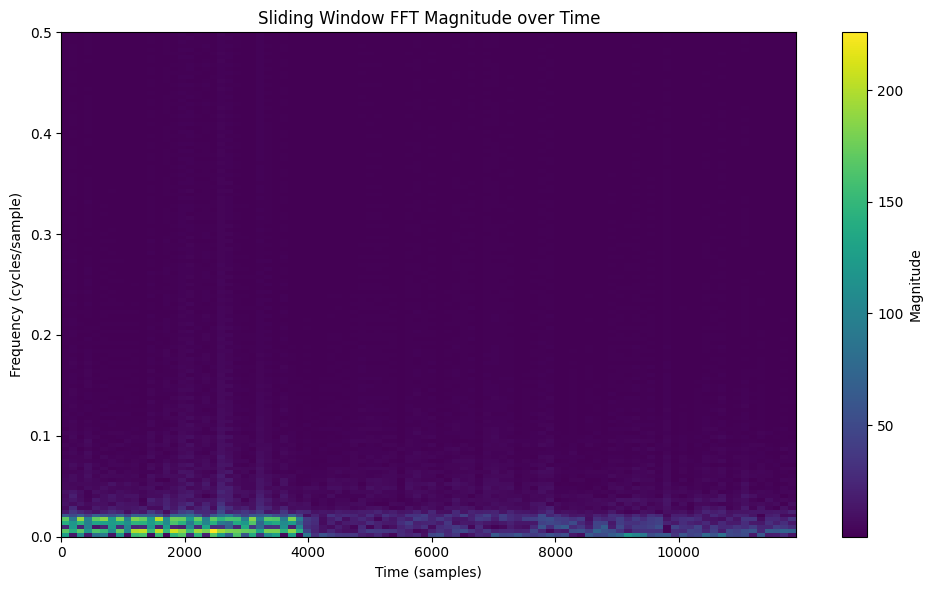

In [684]:
# Select the first channel from X as the signal for FFT analysis
signal = X_ica[:, 0]

# Define window and step sizes
win_size = 256      # window length (number of samples)
step_size = 128     # sliding step

# Calculate the number of windows
num_windows = (len(signal) - win_size) // step_size + 1

# Pre-allocate the spectrogram array (only non-negative frequencies are returned)
spectrogram = np.zeros((num_windows, win_size // 2 + 1))

# Compute FFT for each window and store the magnitude spectrum
for i in range(num_windows):
    start = i * step_size
    window_data = signal[start:start + win_size]
    fft_result = np.fft.rfft(window_data)
    spectrogram[i, :] = np.abs(fft_result)

# Frequency axis for FFT (in cycles per sample)
freqs = np.fft.rfftfreq(win_size, d=1)

# Time axis: here we use the starting index of each window as the time marker
times = np.arange(num_windows) * step_size

# Plot the spectrogram as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times[0], times[-1], freqs[0], freqs[-1]])
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (cycles/sample)')
plt.title('Sliding Window FFT Magnitude over Time')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

31 windows fall in the control segment out of 94 total.

IsolationForest flagged 17 / 94 windows as anomalies.



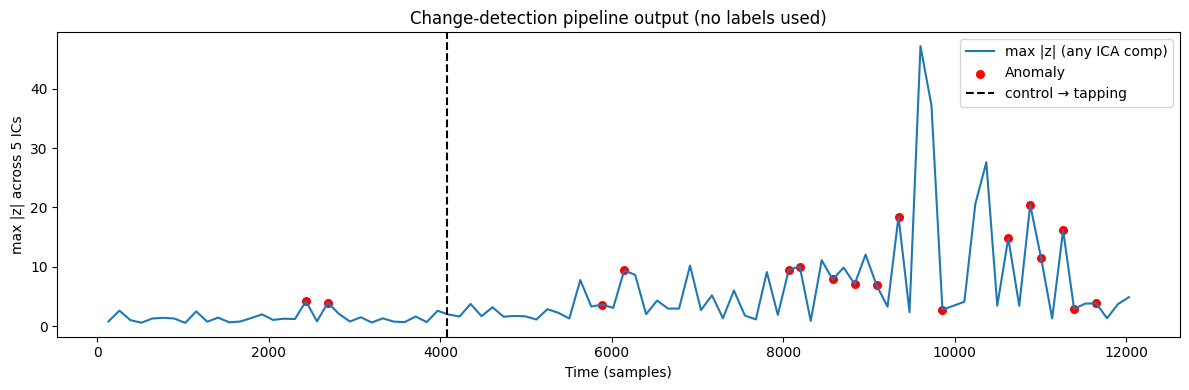

In [685]:
"""
===========================================================
Detecting “something changed” without labels – full pipeline
===========================================================

Inputs
------
X_ica  : numpy array, shape = (n_samples, 5)
         Continuous ICA time-series (5 components) for ONE subject.
control_reshaped, left_reshaped, right_reshaped
       : same number of rows as in the raw epochs used to build X_ica.
         We only need them to know how long the ‘control’ segment is.

What the code does
------------------
1. Slide a short window (256 samples, 50 % overlap) along EACH ICA component.
2. For every window & every component:
     – FFT  ➜  magnitude spectrum  
     – Sum power between 0.04 and 0.15 cycles / sample  
       (this is the classical motor-task band for fNIRS).
3. Convert those band-powers to z-scores **using the control segment
   only** – that makes the units comparable across components & subjects.
4. Collapse the 5 component-z-scores of each window to ONE scalar
   (the maximum absolute z value).  If *any* component reacts, that
   scalar goes up.
5. Feed all z-score vectors from the control period into an
   `IsolationForest`.  Everything that looks “unlike control”
   is flagged as an anomaly ➜ potential tapping attempt.
6. Plot:
     (a) the max-|z| trace over time,
     (b) windows classified as anomalies in red.

No labels are needed anywhere in the pipeline.
"""

# ------------------------------------------------------------------
# 0.  Imports
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# ------------------------------------------------------------------
# 1.  Sliding-window FFT band-power extraction
# ------------------------------------------------------------------
# Parameters you can tweak
WIN_SIZE   = 256   # samples per FFT window
STEP_SIZE  = 128   # how many samples to slide the window
LOW_FREQ   = 0.04  # cycles / sample  (≈ 0.04 Hz if fs = 1 Hz)
HIGH_FREQ  = 0.15  # cycles / sample

# Convenience: total number of windows we can extract
n_samples   = X_ica.shape[0]
n_components = X_ica.shape[1]
n_windows   = (n_samples - WIN_SIZE) // STEP_SIZE + 1

# Pre-allocate: band-power matrix  (n_windows  ×  5 ICA components)
band_power = np.zeros((n_windows, n_components))

# Pre-compute a frequency mask that picks ONLY bins in our band of interest
freqs = np.fft.rfftfreq(WIN_SIZE, d=1)   # cycles / sample
band_mask = (freqs >= LOW_FREQ) & (freqs <= HIGH_FREQ)

# --- main loop: FFT each window & component -----------------------
for w in range(n_windows):
    start = w * STEP_SIZE
    stop  = start + WIN_SIZE
    for comp in range(n_components):
        segment = X_ica[start:stop, comp]          # 1-D slice
        spec    = np.fft.rfft(segment)             # complex FFT
        power   = np.abs(spec)**2                  # magnitude → power
        band_power[w, comp] = power[band_mask].sum()
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# 2.  Build the “window time-axis” (mid-point of each window)
# ------------------------------------------------------------------
window_times = np.arange(n_windows) * STEP_SIZE + WIN_SIZE // 2

# ------------------------------------------------------------------
# 3.  Identify which windows belong to the CONTROL period
# ------------------------------------------------------------------
control_end   = control_reshaped.shape[0]*1          # # samples in control
control_mask  = window_times < control_end         # boolean mask

# Sanity check (optional):
print(f"{control_mask.sum()} windows fall in the control segment out of "
      f"{n_windows} total.\n")

# ------------------------------------------------------------------
# 4.  Z-score each component using CONTROL statistics only
# ------------------------------------------------------------------
z_band_power = np.zeros_like(band_power)
for comp in range(n_components):
    mean_c = band_power[control_mask, comp].mean()
    std_c  = band_power[control_mask, comp].std(ddof=1)
    # guard against numerical issues
    std_c  = std_c if std_c > 0 else 1e-6
    z_band_power[:, comp] = (band_power[:, comp] - mean_c) / std_c

# ------------------------------------------------------------------
# 5.  Collapse the 5-D z vector to ONE scalar per window
#     (max absolute change across components)
# ------------------------------------------------------------------
z_collapse = np.max(np.abs(z_band_power), axis=1)

# ------------------------------------------------------------------
# 6.  Unsupervised anomaly detector  (Isolation Forest)
#     – train ONLY on control windows
#     – score EVERYTHING
# ------------------------------------------------------------------
iso = IsolationForest(
        n_estimators   = 200,
        contamination  = 0.05,   # 5 % of windows are allowed to be “weird”
        random_state   = 42)
iso.fit(z_band_power[control_mask, :])

# `predict` ➜  +1 = in-lier (looks like control)
#              -1 = out-lier (potential tapping)
pred = iso.predict(z_band_power)
is_anomaly = pred == -1

print(f"IsolationForest flagged {is_anomaly.sum()} / {n_windows} "
      f"windows as anomalies.\n")

# ------------------------------------------------------------------
# 7.  Plot the results
# ------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(window_times, z_collapse, label='max |z| (any ICA comp)')
plt.scatter(window_times[is_anomaly],
            z_collapse[is_anomaly],
            color='red', s=30, label='Anomaly')
plt.axvline(control_reshaped.shape[0], color='k', linestyle='--', label='control → tapping')
plt.xlabel('Time (samples)')
plt.ylabel('max |z| across 5 ICs')
plt.title('Change-detection pipeline output (no labels used)')
plt.legend()
plt.tight_layout()
plt.show()


Detected 1 change segment(s):
  1.  3840 → 12032 samples (1048.9 s)


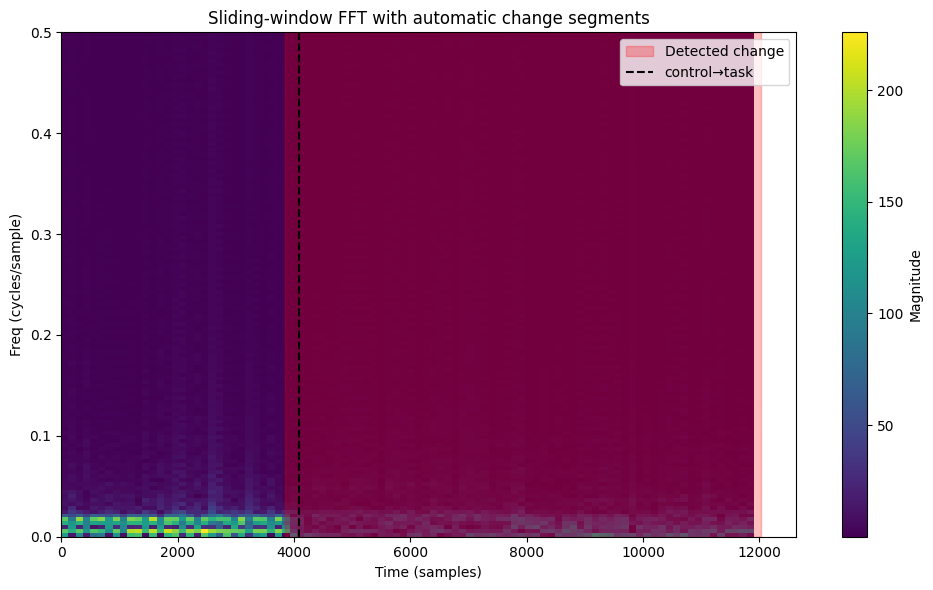

In [686]:
"""
========================================================
Label-free change-segment finder for a spectrogram window
========================================================
Idea
----
1.  Treat the first N seconds (your CONTROL) as the baseline distribution.
2.  For *every* frequency bin f:
      z_f(t) = (mag_f(t) − μ_f,control) / σ_f,control
3.  Mark a time-window t as “different” when **enough bins** exceed |z| > Z_THR.
4.  Merge contiguous “different” windows into longer segments.
5.  Overlay those segments on the spectrogram for instant visual sanity-check.
"""

# ------------------------------------------------------------------
# 0.  Imports
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label  # handy for run-length encoding

# ------------------------------------------------------------------
# 1.  -------  CONFIGURATION  (edit these lines)  -------------------
# ------------------------------------------------------------------
CONTROL_END_SAMPLES = control_reshaped.shape[0]*0.75   # ← already known
freq_mask         = freqs <= 0.05
Z_THRESHOLD         = 2.5         # how many SD away from baseline
PROP_BINS_NEEDED    = 0.10        # ≥20 % of bins must fire together
MIN_WINDOWS_IN_SEG  = 3           # reject too-short blips

# ------------------------------------------------------------------
# 2.  Masks & baseline stats
# ------------------------------------------------------------------
# a) mask the *time* axis – which windows fall inside CONTROL?
control_mask = times < CONTROL_END_SAMPLES

# b) mask the *frequency* axis – restrict to band of interest
# freq_mask = (freqs >= LOW_FREQ_BAND) & (freqs <= HIGH_FREQ_BAND)

# c) compute μ and σ *per-frequency* from control windows
baseline_mean = spectrogram[control_mask][:, freq_mask].mean(axis=0)
baseline_std  = spectrogram[control_mask][:, freq_mask].std(axis=0, ddof=1)
baseline_std[baseline_std == 0] = 1e-6                           # avoid /0

# ------------------------------------------------------------------
# 3.  Z-score the chosen band
# ------------------------------------------------------------------
spec_band   = spectrogram[:, freq_mask]                          # (T × F)
z_band      = (spec_band - baseline_mean) / baseline_std         # same shape
abs_z_band  = np.abs(z_band)                                     # we ignore sign

# ------------------------------------------------------------------
# 4.  Decide if *enough* bins in a window are abnormal
# ------------------------------------------------------------------
# Boolean matrix: True where |z| > Z_THRESHOLD
fires = abs_z_band > Z_THRESHOLD

# For every time-window: proportion of bins that fire
prop_firing = fires.mean(axis=1)

# Binary decision per window
different = prop_firing >= PROP_BINS_NEEDED

# ------------------------------------------------------------------
# 5.  Merge consecutive DIFFERENT windows into segments
# ------------------------------------------------------------------
labeled, n_seg = label(different)                                # run-length encode
segments = []
for seg_id in range(1, n_seg + 1):
    idx = np.where(labeled == seg_id)[0]
    if len(idx) >= MIN_WINDOWS_IN_SEG:
        start_t = times[idx[0]] - WIN_SIZE // 2    # shift back to beginning
        end_t   = times[idx[-1]] + WIN_SIZE // 2
        segments.append((start_t, end_t))

print(f"Detected {len(segments)} change segment(s):")
for s, (t0, t1) in enumerate(segments, 1):
    print(f"  {s}.  {t0:.0f} → {t1:.0f} samples "
          f"({(t1 - t0)/fs:.1f} s)")

# ------------------------------------------------------------------
# 6.  PLOT — spectrogram + shaded change segments
# ------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.T,
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='viridis')
for t0, t1 in segments:
    plt.axvspan(t0, t1, color='red', alpha=0.25, label='Detected change')
plt.axvline(control_reshaped.shape[0], color='k', ls='--', label='control→task')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (samples)')
plt.ylabel('Freq (cycles/sample)')
plt.title('Sliding-window FFT with automatic change segments')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


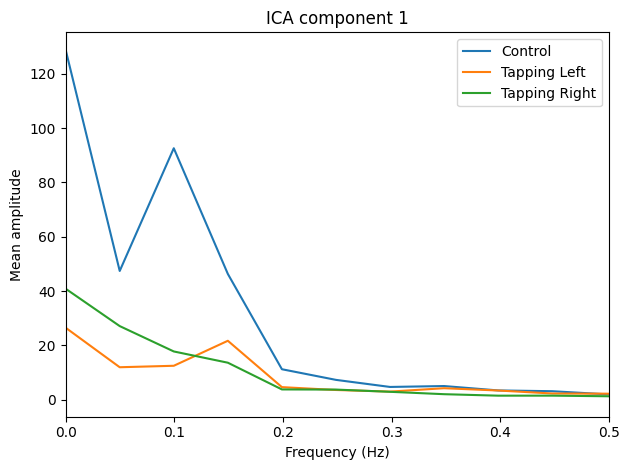

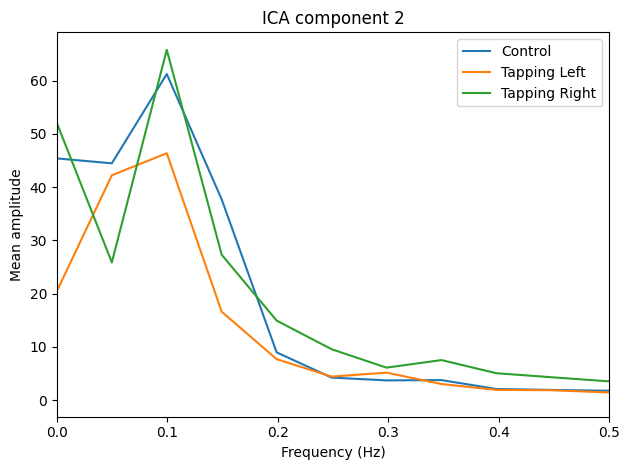

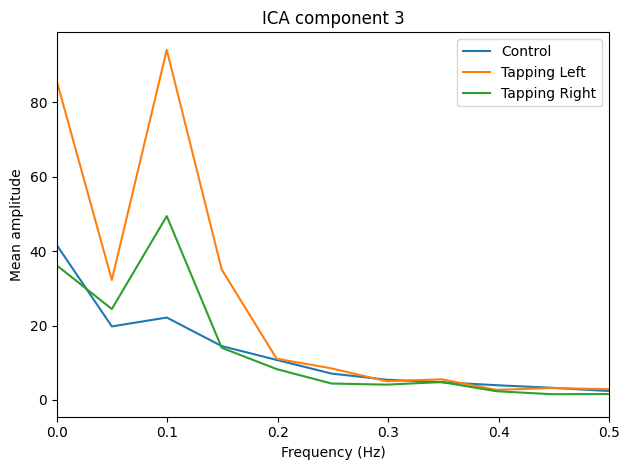

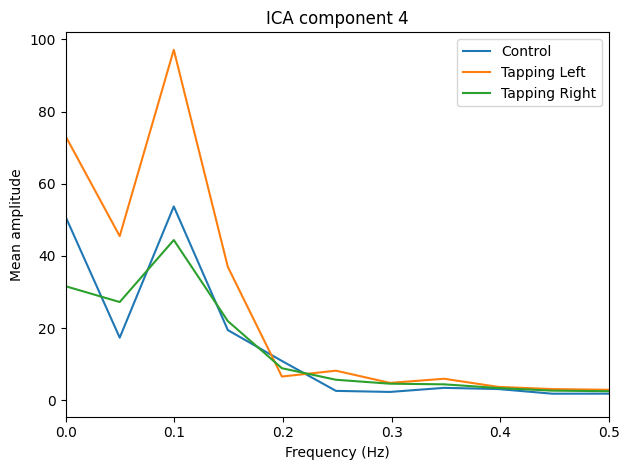

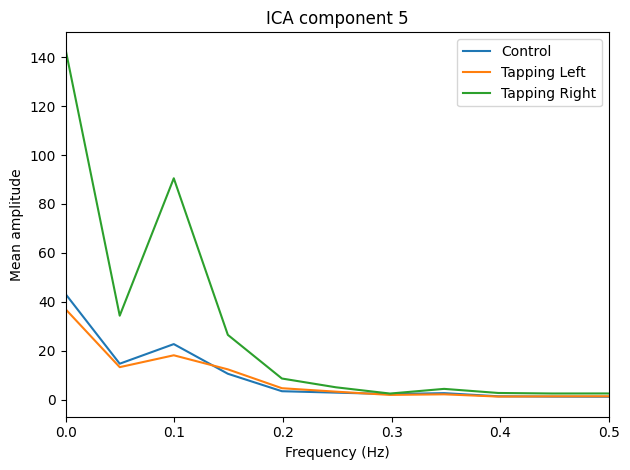

In [687]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

control_ica = X_ica[:l].reshape(min_bound, -1, ica.n_components)
left_ica    = X_ica[l:2*l].reshape(min_bound, -1, ica.n_components)
right_ica   = X_ica[2*l:3*l].reshape(min_bound, -1, ica.n_components)

# --------------------------------------------------------------
# 1)  plug-in: epoch arrays after ICA
#     shape = (n_epochs, n_times, 5)
# --------------------------------------------------------------
control_epochs = control_ica               # ← your variable
left_epochs    = left_ica                  # ← your variable
right_epochs   = right_ica                 # ← your variable
fs             = 7.81                      # sampling rate in Hz
epoch_len      = control_epochs.shape[1]   # points per epoch

# --------------------------------------------------------------
def mean_spectrum(epochs_3d):
    spectra = np.abs(rfft(epochs_3d, axis=1))
    return spectra.mean(axis=0)            # mean over epochs

freqs = rfftfreq(epoch_len, 1 / fs)
control_spec = mean_spectrum(control_epochs)
left_spec    = mean_spectrum(left_epochs)
right_spec   = mean_spectrum(right_epochs)

for comp in range(5):
    plt.figure()
    plt.plot(freqs, control_spec[:, comp], label='Control')
    plt.plot(freqs, left_spec[:, comp],    label='Tapping Left')
    plt.plot(freqs, right_spec[:, comp],   label='Tapping Right')
    plt.xlim(0, 0.5)                       # fNIRS band of interest
    plt.xlabel('Frequency (Hz)');  plt.ylabel('Mean amplitude')
    plt.title(f'ICA component {comp+1}')
    plt.legend();  plt.tight_layout();  plt.show()


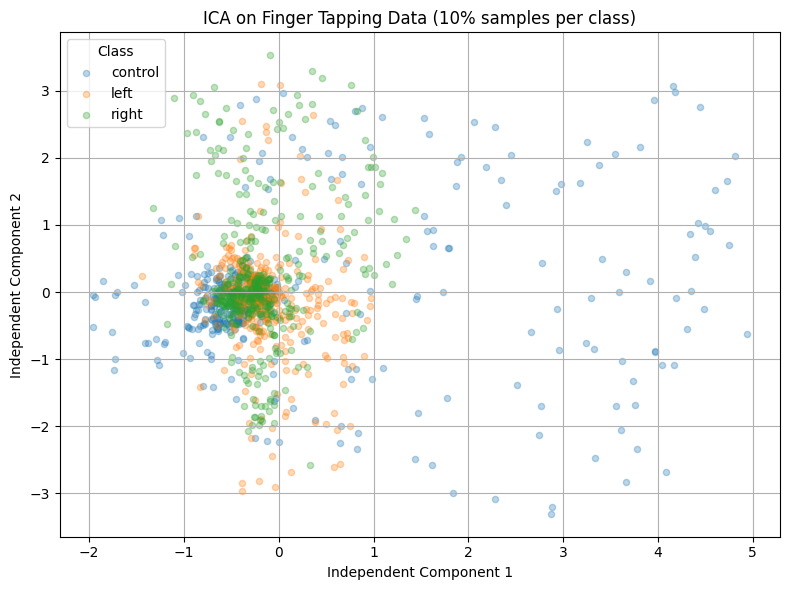

In [688]:
# Mapping labels to names and colors
labels_map = {1: "control", 2: "left", 3: "right"}
colors = {1: "C0", 2: "C1", 3: "C2"}

# Select components to plot
ic_x, ic_y = 0, 1

# % of each class to plot
class_percent = 0.1

plt.figure(figsize=(8, 6))
for label in [1, 2, 3]:
    mask = (y == label)
    indices = np.where(mask)[0]
    # Select 10% of the indices (at least one)
    num_points = max(1, int(len(indices) * class_percent))
    selected = np.random.choice(indices, size=num_points, replace=False)
    plt.scatter(X_ica[selected, ic_x],
                X_ica[selected, ic_y],
                color=colors[label],
                alpha=0.3,
                label=labels_map[label],
                s=20)  # Adjusted size for better visibility

plt.xlabel(f'Independent Component {ic_x + 1}')
plt.ylabel(f'Independent Component {ic_y + 1}')
plt.title(f'ICA on Finger Tapping Data ({class_percent*100:.0f}% samples per class)')
plt.legend(title="Class")
plt.grid()
plt.tight_layout()
plt.show()

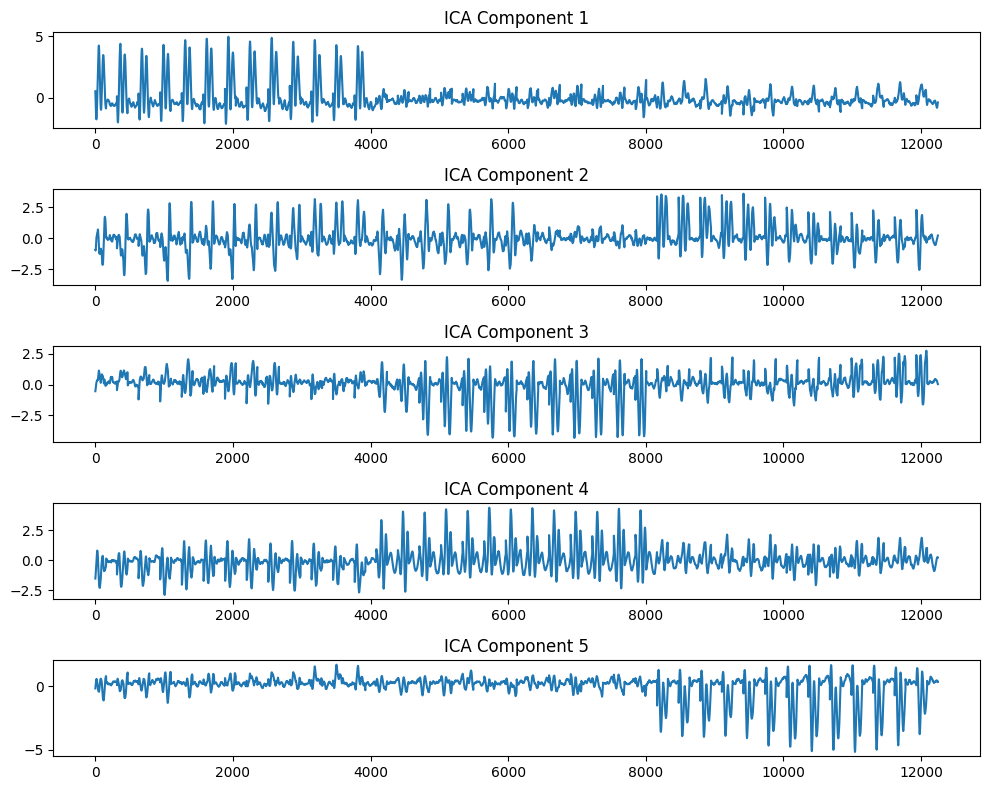

In [689]:
plt.figure(figsize=(10, 8))
for i in range(X_ica.shape[1]):
    plt.subplot(X_ica.shape[1], 1, i + 1)
    plt.plot(X_ica[:, i])
    plt.title(f'ICA Component {i + 1}')
plt.tight_layout()
plt.show()

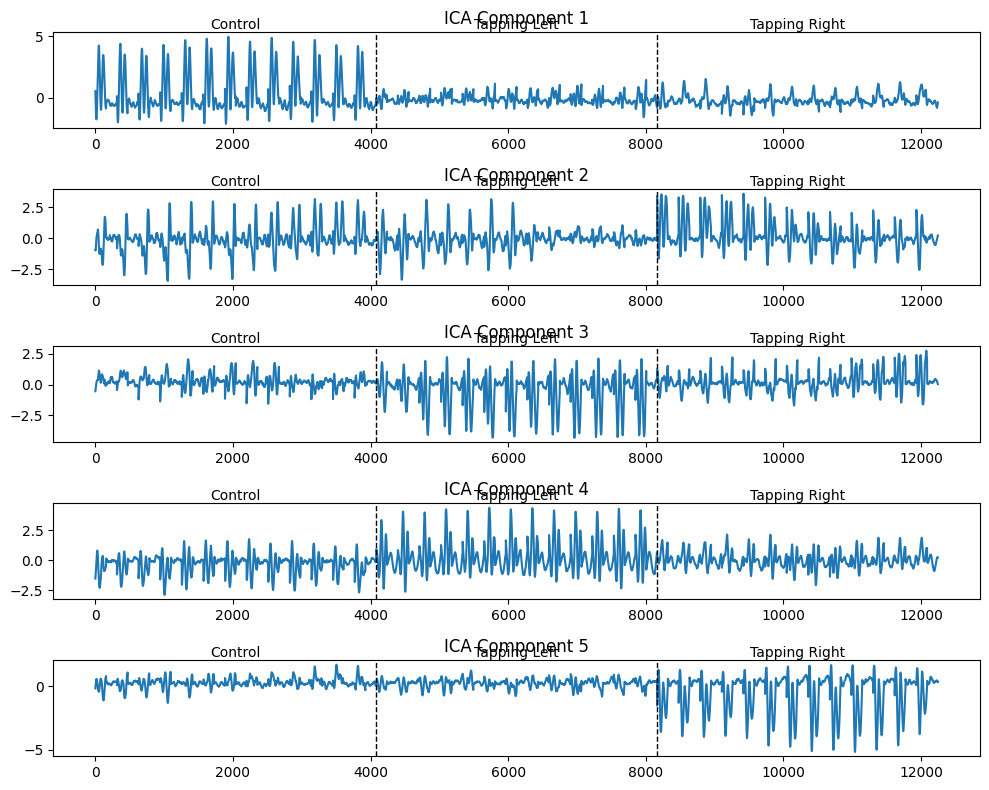

In [690]:
# ...existing code...
plt.figure(figsize=(10, 8))
for i in range(X_ica.shape[1]):
    plt.subplot(X_ica.shape[1], 1, i + 1)
    plt.plot(X_ica[:, i])
    
    # Add vertical lines for epoch boundaries
    plt.axvline(x=l, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=2 * l, color='black', linestyle='--', linewidth=1)
    
    # Get current y-axis limits for positioning the text labels
    y_min, y_max = plt.ylim()
    # Annotate the epochs roughly at the center of each segment
    plt.text(l / 2, y_max, 'Control', horizontalalignment='center', verticalalignment='bottom')
    plt.text(l + l / 2, y_max, 'Tapping Left', horizontalalignment='center', verticalalignment='bottom')
    plt.text(2 * l + l / 2, y_max, 'Tapping Right', horizontalalignment='center', verticalalignment='bottom')
    
    plt.title(f'ICA Component {i + 1}')
plt.tight_layout()
plt.show()